In [52]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms, utils, models

In [25]:
data_dir = r'/media/nghia/DATA/DATA/Bee/bee_imgs/'
PATH = r'/media/nghia/DATA/DATA/Bee/bee_imgs/bee_data.csv'
img_path = r'/media/nghia/DATA/DATA/Bee/bee_imgs/bee_imgs'
print(os.listdir(data_dir))

['.ipynb_checkpoints', 'bee_data.csv', 'bee_imgs', 'pre_train', '__MACOSX']


In [26]:
df = pd.read_csv(PATH)
df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [27]:
df.subspecies.value_counts()

Italian honey bee        3008
Russian honey bee         527
Carniolan honey bee       501
1 Mixed local stock 2     472
-1                        428
VSH Italian honey bee     199
Western honey bee          37
Name: subspecies, dtype: int64

In [28]:
# Return the count of unique values
df['health'].value_counts()

healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64

In [29]:
df['health'] = df['health'].map({'healthy': 0,
                                 'few varrao, hive beetles': 1,
                                 'Varroa, Small Hive Beetles': 2,
                                 'ant problems': 3,
                                 'hive being robbed': 4,
                                 'missing queen': 5})

df["health"].value_counts()

0    3384
1     579
2     472
3     457
4     251
5      29
Name: health, dtype: int64

In [30]:
df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,4,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,4,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,4,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,4,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,4,False,worker


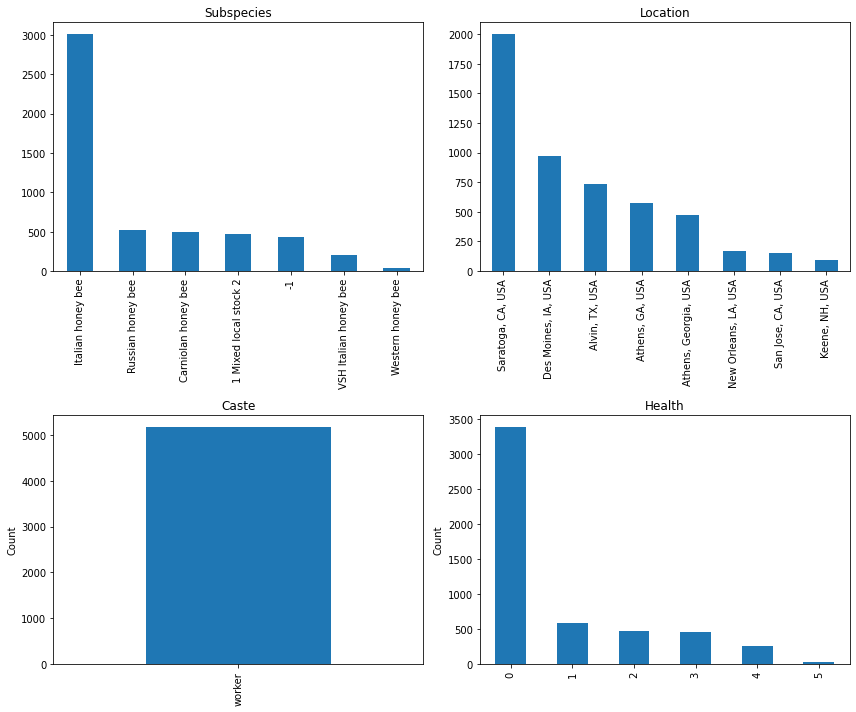

In [31]:
# Plot the graphs wrt different columns
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

df.subspecies.value_counts().plot(kind='bar',ax=ax[0, 0])
ax[0,0].set_title('Subspecies')

df.location.value_counts().plot(kind='bar', ax=ax[0, 1])
ax[0,1].set_title('Location')

df.caste.value_counts().plot(kind='bar', ax=ax[1, 0])
ax[1,0].set_title('Caste')
ax[1,0].set_ylabel('Count')

df.health.value_counts().plot(kind='bar', ax=ax[1,1])
ax[1,1].set_title('Health')
ax[1,1].set_ylabel('Count')

f.tight_layout()
plt.show()

In [32]:
transform = {'train': transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
                                          #transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])]),

             'val': transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])]),

             'test': transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])}

# Check for cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Custom dataset

In [33]:
class HoneyBeeDataset(Dataset):
    # instance attributes
    def __init__(self, df, csv_file, root_dir, transform=None):
        self.data = df
        self.root_dir = root_dir
        self.labels = np.asarray(self.data.iloc[:, 6])
        self.transform = transform

    # length of the dataset passed to this class method
    def __len__(self):
        return len(self.data)

    # get the specific image and labels given the index
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        image = image.convert('RGB')
        image_label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, image_label

In [34]:
dataset = HoneyBeeDataset(df=df,
                          csv_file=PATH,
                          root_dir=img_path)

In [35]:
validation_split = 0.2
te_split = 0.5
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)
val_split = int(np.floor(validation_split * dataset_size))
test_split = int(np.floor(te_split * val_split))
train_indices = indices[val_split:]
rest_indices = indices[:val_split]
val_indices, test_indices = rest_indices[test_split:], rest_indices[:test_split]

In [36]:
# Sanity Check
# Expected outcome: 4138, 517, 517
len(train_indices), len(val_indices), len(test_indices)

(4138, 517, 517)

In [37]:
dataset_sizes = {'train': len(train_indices), 'val': len(val_indices), 'test': len(test_indices)}

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataset = HoneyBeeDataset(df=df,
                                csv_file=PATH,
                                root_dir=img_path,
                                transform=transform['train'])

val_dataset = HoneyBeeDataset(df=df,
                              csv_file=PATH,
                              root_dir=img_path,
                              transform=transform['val'])

test_dataset = HoneyBeeDataset(df=df,
                               csv_file=PATH,
                               root_dir=img_path,
                               transform=transform['test'])

In [49]:
train_dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


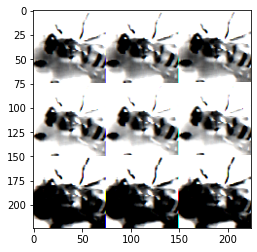

In [59]:
x, y = train_dataset.__getitem__(2)
x = x.reshape(224,224,3)
plt.imshow(x.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


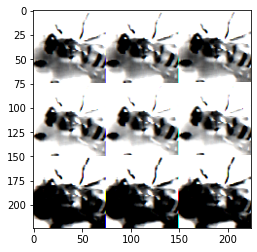

In [64]:
x1 = x.permute(0, 1, 2)
plt.imshow(x1)

In [57]:
# Display image and label.
train_features, train_labels = next(iter(train_dataset))
print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(img.shape)
plt.imshow(img[2,:,:])
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([3, 224, 224])


IndexError: invalid index to scalar variable.

In [38]:
dataloaders = {'train' : torch.utils.data.DataLoader(train_dataset, batch_size=4, sampler=train_sampler),
               'val': torch.utils.data.DataLoader(val_dataset, batch_size=4, sampler=valid_sampler),
               'test': torch.utils.data.DataLoader(test_dataset, batch_size=1, sampler=test_sampler)}

In [39]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    #copy the best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch, num_epochs-1))
        print("="*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase=='train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# VGG-16 models
1. Features
2. Classifier
We are going to use the same weights of the pretrained model so we won't be computing gradients on that part of the model. The last layer of the classifier part of the model has out_features = 1000 we are going to replace that layer by another layer with out_features = 4.

In [40]:
# Load VGG16 Model
model_pre = models.vgg16()
model_pre.load_state_dict(torch.load('/media/nghia/DATA/DATA/Bee/bee_imgs/pre_train/vgg16-397923af.pth'))

<All keys matched successfully>

In [41]:
model_pre

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [42]:
# don't calculate gradient since we will use the weights of pretrained model
for param in model_pre.features.parameters():
    param.required_grad = False

num_features = model_pre.classifier[6].in_features
# Remove last layer
features = list(model_pre.classifier.children())[:-1]
# Add new layer with out_features = len(health_classes)
features.extend([nn.Linear(num_features, 6)])
# Replace the model classifier with new classifier
model_pre.classifier = nn.Sequential(*features)
print(model_pre.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=6, bias=True)
)


In [43]:
# load gpu
model_pre = model_pre.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [44]:
EPOCHS = 35
# train
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch: 0/34


/home/nghia/CNU-SEM3/AI_proj/Bee_Health/Eagle-Vision/streamlit/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.5580 Acc: 0.7924
val Loss: 0.3993 Acc: 0.8356
Epoch: 1/34
train Loss: 0.2835 Acc: 0.8932
val Loss: 0.2916 Acc: 0.8897
Epoch: 2/34
train Loss: 0.1753 Acc: 0.9335
val Loss: 0.2293 Acc: 0.9110
Epoch: 3/34
train Loss: 0.1334 Acc: 0.9509
val Loss: 0.2794 Acc: 0.8820
Epoch: 4/34
train Loss: 0.1271 Acc: 0.9555
val Loss: 0.1963 Acc: 0.9246
Epoch: 5/34
train Loss: 0.1316 Acc: 0.9541
val Loss: 0.2679 Acc: 0.9033
Epoch: 6/34
train Loss: 0.0910 Acc: 0.9650
val Loss: 0.1469 Acc: 0.9439
Epoch: 7/34
train Loss: 0.0701 Acc: 0.9770
val Loss: 0.1362 Acc: 0.9439
Epoch: 8/34
train Loss: 0.0535 Acc: 0.9826
val Loss: 0.5721 Acc: 0.8781
Epoch: 9/34
train Loss: 0.0350 Acc: 0.9911
val Loss: 0.1084 Acc: 0.9613
Epoch: 10/34
train Loss: 0.0119 Acc: 0.9969
val Loss: 0.1059 Acc: 0.9594
Epoch: 11/34
train Loss: 0.0069 Acc: 0.9990
val Loss: 0.1122 Acc: 0.9652
Epoch: 12/34
train Loss: 0.0051 Acc: 0.9995
val Loss: 0.1155 Acc: 0.9632
Epoch: 13/34
train Loss: 0.0032 Acc: 1.0000
val Loss: 0.1162 Acc: 0.9632


In [45]:
def test_model():
    running_correct = 0
    running_total = 0
    true_labels = []
    pred_labels = []
    # no gradient calculation
    with torch.no_grad():
        for data in dataloaders['test']:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
    return (true_labels, pred_labels, running_correct, running_total)

In [46]:
true_labels, pred_labels, running_correct, running_total= test_model()
print('Correct: {}, Total: {}'.format(running_correct, running_total))
print('Test Accuracy: ', (running_correct/running_total))

Correct: 500, Total: 517
Test Accuracy:  0.9671179883945842


In [66]:
# clf report
from sklearn.metrics import classification_report, precision_recall_fscore_support
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       349
           1       0.85      0.85      0.85        52
           2       0.83      0.83      0.83        48
           3       1.00      1.00      1.00        47
           4       0.94      1.00      0.97        16
           5       1.00      0.80      0.89         5

    accuracy                           0.97       517
   macro avg       0.94      0.91      0.92       517
weighted avg       0.97      0.97      0.97       517



In [74]:
precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

(0.9672317669814541, 0.9671179883945842, 0.967039837446027, None)